In [1]:
#Module configuration
#from py2neo import Graph #Database connection
import neomodel
import pandas as pd
import datetime
import numpy as np
import torch
import torch.nn as nn
import random
import os

In [2]:
#Config
# Parameters :

#Structuration of the acte in the graph database -> See directly in the cell
#Nb of Embedings dimensions in Node2vec:
embeddingNbDimensions = 3

#Size of the Carepath extraction
def size_of_CP_to_learn(Maxlength):
    size = Maxlength
    #size = 100
    return size

n_hidden = 10
lr=0.01
criterion = nn.MSELoss()  # Suitable loss function

#nn.NLLLoss()  nn.CrossEntropyLoss() nn.MSELoss()

myFileName='DL_Project_Dataset_Sample_V5.csv'
#'DataCP_Example/CP_Category_1.csv'
#DL_Project_Dataset_Sample_V5.csv
#'Dataset_Simple_V0.csv'
#'DL_Project_Dataset_LongCP_Cluster1-772Patients.csv'
renew_database=True


In [3]:
from neomodel import config

neo4jServerAdress = "172.21.56.47"
neo4jConnectionPort = 7687  #Connection to server bolt
user= "neo4j" 
password= "Mypassword%2023"
config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

In [4]:
from neomodel import (config, StructuredNode, StringProperty, IntegerProperty,DateTimeProperty,
                    DateTimeFormatProperty,UniqueIdProperty, RelationshipTo,StructuredRel)

config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

#NIP	J_Parcours	DateDebutActe	DateFinActe	UF	Service	Phase_Parcours	Activite	Dimension_Parcours	Ref_Acte	id_Sequence	Type_Sequence	id_sejour

class FOLLOWED_BY(StructuredRel):
    #Nb_Days = IntegerProperty(index=True, default=0)
    Next_Acte_from_JP = IntegerProperty(index=True, default=0)
    NIP=StringProperty(required=False)

class Acte(StructuredNode):
    Ref_Acte = StringProperty(required=True)
    #J_Parcours=IntegerProperty(required=False)
    #Duree = IntegerProperty(required=False)
    UF = StringProperty(required=True)
    #Service = StringProperty(required=True)
    #Phase_Parcours =StringProperty(required=True)
    #Activite =StringProperty(required=True)
    #Dimension_Parcours = StringProperty(required=True)
    #Nombre_actes=IntegerProperty(required=False, default=1)     
    Carepath = RelationshipTo('Acte', 'FOLLOWED_BY', model=FOLLOWED_BY)

class Patient(StructuredNode):
    NIP = StringProperty(unique_index=True, required=True)
    J0 = StringProperty(required=True)
    J_Parcours = IntegerProperty(required=False, default=0)
    Carepath = RelationshipTo('Acte', 'BEGIN_CAREPATH_WITH', model=FOLLOWED_BY)

In [5]:
# Define the filepath of the import csvfile
file_path = os.path.join('..', '01_Datasets', myFileName)
#file_path = r'..\01_Datasets\{myFileName}'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';')
# Display the first few rows of the DataFrame
df

,NIP,J_Parcours,DateDebutActe,DateFinActe,UF,Service,Phase_Parcours,Activite,Dimension_Parcours,Ref_Acte,id_Sequence,Type_Sequence,id_sejour
0,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,8532,Médecine Nucléaire,Diagnostic,TEP,Soins,FTNTP2,12513,INIT_NEW,N1771659
1,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,8532,Médecine Nucléaire,Diagnostic,TEP,Soins,ZZQL016,12513,INIT_NEW,N1771659
2,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,1001,Médecine Nucléaire,Diagnostic,TEP,Soins,FTNTP2,12513,INIT_NEW,N160017801
3,N201900002,37,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,9050,Radiothérapie,Consultation,Consultations,Soins,CS,12513,INIT_NEW,N1791270
4,N201900002,37,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,9050,Radiothérapie,Consultation,Consultations,Soins,MCS,12513,INIT_NEW,N1791270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,1609,12809,SUIVI_LT,N2134149
1907,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,514,12809,SUIVI_LT,N2134149
1908,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,9005,12809,SUIVI_LT,N2134149
1909,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,522,12809,SUIVI_LT,N2134149


Ref_Acte
MCS        0.101518
CS         0.098378
ZZNL051    0.057561
MPC        0.054422
ZZNL054    0.046049
             ...   
9080       0.000523
ZBQH001    0.000523
996        0.000523
7420       0.000523
ZZQX122    0.000523
Name: proportion, Length: 192, dtype: float64


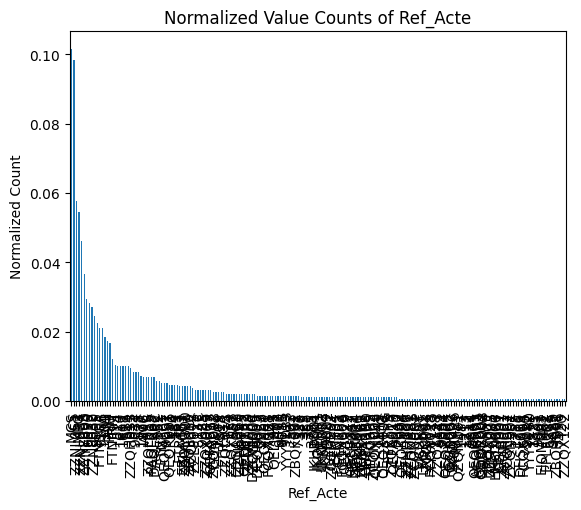

Ref_Acte
MCS        0.101518
CS         0.098378
ZZNL051    0.057561
MPC        0.054422
ZZNL054    0.046049
             ...   
QEEB152    0.002093
FTNTP2     0.002093
ZZNL059    0.002093
DZQM006    0.002093
ZCQJ004    0.002093
Name: proportion, Length: 72, dtype: float64


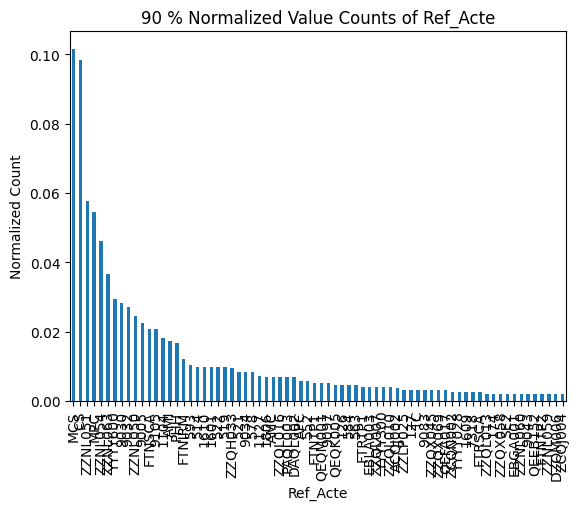

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


cut= 90
#DATA ANALYSIS / FILTERING
Actes_summary_normalized = df['Ref_Acte'].value_counts(normalize=True)
print(Actes_summary_normalized)

# Plot the normalized value counts
Actes_summary_normalized.plot(kind='bar')
plt.title('Normalized Value Counts of Ref_Acte')
plt.xlabel('Ref_Acte')
plt.ylabel('Normalized Count')
plt.show()

# Calculate the cumulative sum of normalized value counts
cumulative_sum = Actes_summary_normalized.cumsum()
# Filter 'Ref_Acte' values that contribute to the top 90% of occurrences
top_90_percent = Actes_summary_normalized[cumulative_sum <= cut/100]
# Display the filtered 'Ref_Acte' values
print(top_90_percent)

# Plot the normalized value counts
top_90_percent.plot(kind='bar')
plt.title(f'{cut} % Normalized Value Counts of Ref_Acte')
plt.xlabel('Ref_Acte')
plt.ylabel('Normalized Count')
plt.show()



In [7]:
# One-hot encode 'UF' and 'Ref_Acte' columns
uf_encoded = pd.get_dummies(df['UF'], prefix='UF')
ref_acte_encoded = pd.get_dummies(df['Ref_Acte'], prefix='Ref_Acte')

# Concatenate 'id_sejour' column with one-hot encoded columns
result=pd.concat([df['id_sejour'], ref_acte_encoded], axis=1)
#result = pd.concat([df['id_sejour'], uf_encoded, ref_acte_encoded], axis=1)

# Group by 'id_sejour' and sum the one-hot encoded columns
result_grouped = result.groupby('id_sejour').sum().reset_index()
print(result_grouped)

      id_sejour  Ref_Acte_1104  Ref_Acte_1127  Ref_Acte_1128  Ref_Acte_1141  \
0    N160017801              0              0              0              0   
1    N160017817              0              0              0              0   
2    N160017844              0              0              0              0   
3    N160017905              0              0              0              0   
4    N160018388              0              0              0              0   
..          ...            ...            ...            ...            ...   
752    N2136439              0              0              0              0   
753    N2137508              0              0              0              0   
754    N2140309              0              0              0              0   
755    N2142602              0              0              0              0   
756    N2142740              0              0              0              0   

     Ref_Acte_1211  Ref_Acte_1212  Ref_Acte_1213  R

c:\Anaconda\envs\DL_Project2\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Anaconda\envs\DL_Project2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Anaconda\envs\DL_Project2\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Anaconda\envs\DL_Project2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL

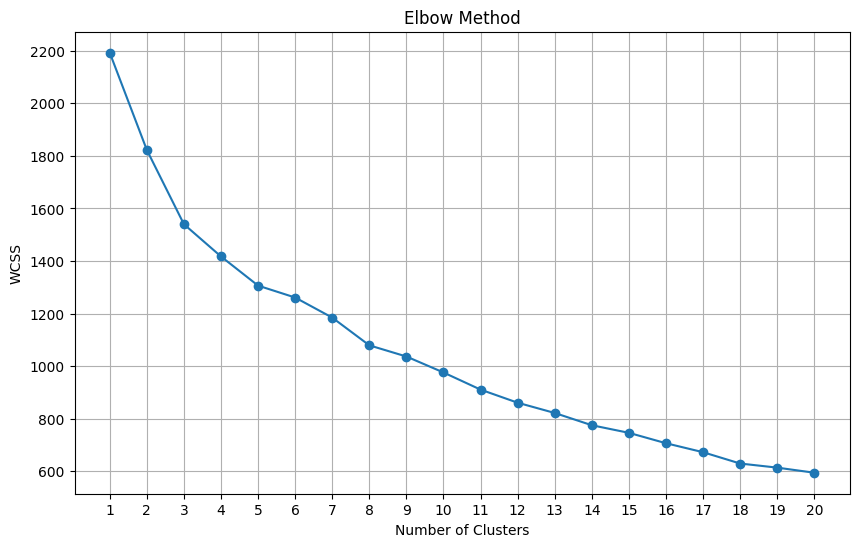

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Remove 'id_sejour' if it's not numerical
data = result_grouped.drop('id_sejour', axis=1)

# Find optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 21):  # Trying up to 20 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 21, 1))
plt.grid(True)
plt.show()


c:\Anaconda\envs\DL_Project2\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Anaconda\envs\DL_Project2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


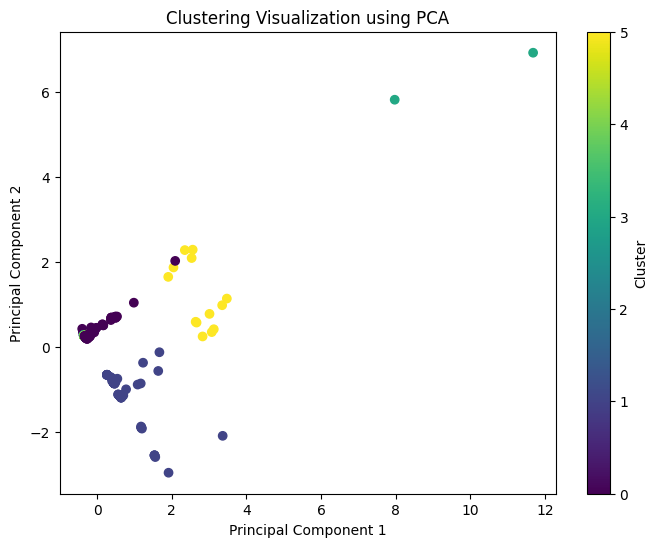

In [9]:
# From the plot, choose the optimal number of clusters
optimal_clusters = 6  # Example, choose based on the plot

# Perform KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(data)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Visualize the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Visualization using PCA')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
# Add cluster labels to the original dataframe
data['Cluster'] = clusters

# Calculate mean of each cluster's individuals
cluster_means = data.groupby('Cluster').mean()

In [11]:
cluster_means

,Ref_Acte_1104,Ref_Acte_1127,Ref_Acte_1128,Ref_Acte_1141,Ref_Acte_1211,Ref_Acte_1212,Ref_Acte_1213,Ref_Acte_126,Ref_Acte_127,Ref_Acte_1487,...,Ref_Acte_ZZQN001,Ref_Acte_ZZQX027,Ref_Acte_ZZQX045,Ref_Acte_ZZQX058,Ref_Acte_ZZQX069,Ref_Acte_ZZQX077,Ref_Acte_ZZQX081,Ref_Acte_ZZQX122,Ref_Acte_ZZQX123,Ref_Acte_ZZQX162
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.027719,0.004264,0.000000,0.002132,0.000000,0.000000,0.000000,0.004264,0.002132,0.000000,...,0.002132,0.004264,0.012793,0.008529,0.012793,0.002132,0.002132,0.002132,0.002132,0.004264
1,0.017442,0.011628,0.005814,0.005814,0.005814,0.000000,0.000000,0.005814,0.005814,0.005814,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.000000,0.461538,0.000000,0.000000,0.000000,0.076923,0.076923,0.307692,0.153846,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
#Apply the clustering to the original dataframe and create a new simplified dataframe
result_grouped['Cluster'] = clusters
# Merge the grouped dataframe back to the original dataframe on 'id_sejour' column
df = df.merge(result_grouped[['id_sejour', 'Cluster']], on='id_sejour', how='left')
df

,NIP,J_Parcours,DateDebutActe,DateFinActe,UF,Service,Phase_Parcours,Activite,Dimension_Parcours,Ref_Acte,id_Sequence,Type_Sequence,id_sejour,Cluster
0,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,8532,Médecine Nucléaire,Diagnostic,TEP,Soins,FTNTP2,12513,INIT_NEW,N1771659,0
1,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,8532,Médecine Nucléaire,Diagnostic,TEP,Soins,ZZQL016,12513,INIT_NEW,N1771659,0
2,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,1001,Médecine Nucléaire,Diagnostic,TEP,Soins,FTNTP2,12513,INIT_NEW,N160017801,0
3,N201900002,37,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,9050,Radiothérapie,Consultation,Consultations,Soins,CS,12513,INIT_NEW,N1791270,1
4,N201900002,37,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,9050,Radiothérapie,Consultation,Consultations,Soins,MCS,12513,INIT_NEW,N1791270,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,1609,12809,SUIVI_LT,N2134149,5
1907,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,514,12809,SUIVI_LT,N2134149,5
1908,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,9005,12809,SUIVI_LT,N2134149,5
1909,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,522,12809,SUIVI_LT,N2134149,5


In [13]:
#Construct a "normalized" Sejour from the clustering
data

,Ref_Acte_1104,Ref_Acte_1127,Ref_Acte_1128,Ref_Acte_1141,Ref_Acte_1211,Ref_Acte_1212,Ref_Acte_1213,Ref_Acte_126,Ref_Acte_127,Ref_Acte_1487,...,Ref_Acte_ZZQX027,Ref_Acte_ZZQX045,Ref_Acte_ZZQX058,Ref_Acte_ZZQX069,Ref_Acte_ZZQX077,Ref_Acte_ZZQX081,Ref_Acte_ZZQX122,Ref_Acte_ZZQX123,Ref_Acte_ZZQX162,Cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
#Function to extract information from a row
date_format = '%Y-%m-%d %H:%M:%S.%f'

def extract_data(row):
    from datetime import datetime
    acte = {
        'Jp': row.get('J_Parcours', None),
        'DDA': datetime.strptime(row.get('DateDebutActe', None), date_format),
        'DDF': datetime.strptime(row.get('DateFinActe', None), date_format),
        'Ref': row.get('Ref_Acte', None),
        'NIP': row.get('NIP', None),
        'UFname': str(row.get('UF', None)),
        'service': row.get('Service', None),
        'phase_parcours': row.get('Phase_Parcours', None).replace(" ", ""),
        'activite': row.get('Activite', None),
        'dim_parcours': row.get('Dimension_Parcours', None),
        'Sequence_id': row.get('id_Sequence', None),
        'Sequence_Type': row.get('Type_Sequence', None),
        'Sejour_id': row.get('id_sejour', None),
        'Cluster': row.get('Cluster', None)
    }

    return acte

In [15]:
#Define a query function
def myquery(query, params=None):
    from neomodel import db
    results, meta = db.cypher_query(query, params, resolve_objects=True)
    
    
    return results, meta

In [16]:
#Append to a node tuple

def myappend(alist,value):
    if not isinstance(alist, list):
        newlist=[alist]
    else:
        newlist=alist
    newlist.append(value)

    return newlist

In [17]:
#Define a function to create a new acte 
def create_acte(myActe):
    try:
        # Check if an existing Node Acte already exists.
        existing_acte = Acte.nodes.filter(Ref_Acte=myActe['Ref'], UF=myActe['UFname']).first()

        # If YES: Return the existing Acte
        if existing_acte:
            return existing_acte

    except Acte.DoesNotExist:
        # Handle the case where the Acte node does not exist
        pass

    #IF NO : CREATE A NEW ACTE AND RETURN IT.
    new_acte=Acte(
                    Ref_Acte = myActe['Ref'],
                    #Duree = int((myActe['DDF'] - myActe['DDA']).total_seconds()),
                    #J_Parcours = myActe['Jp'],
                    UF = myActe['UFname'],
                    #Service = myActe['service'],
                    #Phase_Parcours = myActe['phase_parcours'],
                    #Activite = myActe['activite'],
                    #Dimension_Parcours = myActe['dim_parcours'],
                ).save()
    return new_acte

def update_acte(myNodeActe, myNewActe):
    
    #Check if J_Parcours is th same between NodeActe and NewActe
    #if myNodeActe.J_Parcours==myNewActe['Jp']:
    myNodeActe.Ref_Acte=myappend(myNodeActe.Ref_Acte,myNewActe['Ref'])
    myNodeActe.UF=myappend(myNodeActe.UF,myNewActe['UFname'])
    #myNodeActe.Service=myappend(myNodeActe.Service,myNewActe['service'])
    #myNodeActe.Phase_Parcours=myappend(myNodeActe.Phase_Parcours,myNewActe['phase_parcours'])
    #myNodeActe.Activite=myappend(myNodeActe.Activite,myNewActe['activite'])
    #myNodeActe.Dimension_Parcours=myappend(myNodeActe.Dimension_Parcours,myNewActe['dim_parcours'])
    #myNodeActe.Nombre_actes=myNodeActe.Nombre_actes+1
    myNodeActe.save()
        
    #else:
    #    raise (f"Error in Updating Node {myNodeActe.id}, the new Acte doesn't have the same J parcours !")

    return myNodeActe

def create_Startnode(myActe):
    startNode=Patient(
                    NIP = myActe['NIP'],
                    J0 = myActe['DDA']
                    ).save()
    return startNode


def close_Carepath(NIP,JP,Active_Node):
    #Create a specific Acte 'End of Carepath'Acte
    
    myEndActe = {
        'Jp': JP,
        #'DDA': datetime.strptime(row.get('DateDebutActe', None), date_format),
        #'DDF': datetime.strptime(row.get('DateFinActe', None), date_format),
        'Ref': 'END_CP',
        'NIP': NIP,
        'UFname': 'END_CP',
        #'service': row.get('Service', None),
        #'phase_parcours': row.get('Phase_Parcours', None).replace(" ", ""),
        #'activite': row.get('Activite', None),
        #'dim_parcours': row.get('Dimension_Parcours', None),
        #'Sequence_id': row.get('id_Sequence', None),
        #'Sequence_Type': row.get('Type_Sequence', None),
        #'Sejour_id': row.get('id_sejour', None)
    }
    
    End_acte=create_acte(myEndActe)

    #Connect this end_acte to the active Node
    Active_Node.Carepath.connect(End_acte, {'Next_Acte_from_JP': myEndActe['Jp'] ,'NIP': myEndActe['NIP'] })
    
    return None

In [18]:
if renew_database:
    #MODELIZATION 5 : 
    #NOEUDS : ACTES , DIFFERENTIATED BY PHASE PARCOURS.
    #RELATIONS : 
        # START : for the first acte
        # ACTES REALIZED BY DAY

    #INITIALISATION   #CLEAR THE DATABASE
    query="MATCH (n) DETACH DELETE n"
    myquery(query)

    Start=True
    output=True

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        # Extract values from the DataFrame
        myActe = extract_data(row)

        if Start:
            #Create a new acte
            new_acte=create_acte(myActe)
            Active_Node=new_acte
            
            #Create a start node
            startNode=create_Startnode(myActe)

            #LINK THE START NODE TO THE ACTES
            startNode.Carepath.connect(new_acte)
            Start=False

            #SET THE START NODE AS THE PREVIOUS NODE
            Previous_Node=startNode

        else:
            if oldActe['NIP']!=myActe['NIP']: #Check if we are dealing with the same patient
                
                #Close the previous Carepath
                close_Carepath(oldActe['NIP'],oldActe['Jp'],Active_Node)
                
                #Create a new acte
                new_acte=create_acte(myActe)
                
                Active_Node=new_acte
                
                #Create a start node
                startNode=create_Startnode(myActe)

                #LINK THE START NODE TO THE ACTES
                startNode.Carepath.connect(new_acte)
                #SET THE START NODE AS THE PREVIOUS NODE
                Previous_Node=startNode

            else:            
                #Check if we have to change the previous node
                if myActe['Jp']!=oldActe['Jp']:
                    #Create a new acte
                    new_acte=create_acte(myActe)

                    Previous_Node=Active_Node
                    Active_Node=new_acte

                    #LINK THE ACTE TO THE PREVIOUS ONE
                    Previous_Node.Carepath.connect(new_acte, {'Next_Acte_from_JP': myActe['Jp'] ,'NIP': myActe['NIP'] })

                else:
                    #update the active node
                    new_acte=update_acte(Active_Node,myActe)
                    #Active_Nodes.append(new_acte)

        #Store the acte in a variable oldActe
        oldActe=myActe


    #We are at the last line of the file, we need to close the last carepath as well
    close_Carepath(myActe['NIP'],myActe['Jp'],Active_Node)

In [19]:
#Get the id of the EndActe
End_acte = Acte.nodes.filter(Ref_Acte='END_CP', UF='END_CP').first()


In [20]:
End_acte.element_id

# Split the string by ':' to get the parts separated by colon
parts = End_acte.element_id.split(':')

# Get the last part of the split string and then split again by ':' to extract the final portion
End_acteid = int(parts[-1].split(':')[-1])

End_acteid

814

In [21]:
#List exsiting graph in the database
from neomodel import db
query = """
CALL gds.graph.list()
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
ORDER BY graphName ASC
"""
results = db.cypher_query(query)
results

([['Mygraph', 366, 739]], ['graphName', 'nodeCount', 'relationshipCount'])

In [22]:

#delete all existings graphs
for graph in results[0]:
    query = f"""
            CALL gds.graph.drop('{graph[0]}') YIELD graphName;
            """
    results = db.cypher_query(query)

In [23]:
#Node Embedings

#Create an in-Memory graph:
query = """
CALL gds.graph.project(
  'Mygraph',
  'Acte',
  'FOLLOWED_BY',
  {
    relationshipProperties: 'Nb_Days'
  }
)
"""
results = db.cypher_query(query)


In [24]:
# If you need to specify a number of dimension :
#CALL gds.node2vec.stream('Mygraph', {embeddingDimension: 2})
#If you don't need to specify a number of dimension:
#CALL gds.node2vec.stream('Mygraph')


#run the node2vec algorithm:
if embeddingNbDimensions==None:
    query = """
    CALL gds.node2vec.stream('Mygraph')
    YIELD nodeId, embedding
    RETURN nodeId, embedding
    """
else:
    query = f"""
    CALL gds.node2vec.stream('Mygraph', {{embeddingDimension: {embeddingNbDimensions}}})
    YIELD nodeId, embedding
    RETURN nodeId, embedding
    """

from neomodel import db
results = db.cypher_query(query)

nb_ebemdings_dimensions=len(results[0][0][1])

In [25]:
results

([[781, [0.10587553679943085, 0.24524331092834473, -0.4098292291164398]],
  [783, [-0.04941017925739288, 0.8981754779815674, -1.0820341110229492]],
  [784, [-0.01037864200770855, 1.4117897748947144, -1.5428556203842163]],
  [785, [0.12587076425552368, 1.6354968547821045, -1.9615398645401]],
  [786, [1.211609959602356, 1.8950904607772827, -2.5134613513946533]],
  [787, [1.2477227449417114, 1.4088629484176636, -2.503267765045166]],
  [788, [1.4424324035644531, 1.448630452156067, -2.596144199371338]],
  [789, [1.7140793800354004, 1.6991223096847534, -3.3396847248077393]],
  [790, [1.4851353168487549, 0.16574782133102417, -3.6566572189331055]],
  [791, [1.6181142330169678, 0.28516483306884766, -3.4112372398376465]],
  [792, [1.4803764820098877, 0.23871324956417084, -3.549032211303711]],
  [793, [1.065079689025879, 0.1483524590730667, -2.9168548583984375]],
  [794, [1.3268465995788574, 0.05828284099698067, -3.4931726455688477]],
  [795, [1.7507519721984863, 0.41093096137046814, -3.403283596

In [26]:
#convert the result variable into a dict
Dict_embedings = {}

for entry in results[0]:
    node_id = entry[0]
    embedding = entry[1]
    Dict_embedings[node_id] = {'Embedding': embedding}

In [27]:
#add a zero acte at index zero
Dict_embedings[0] = {'Embedding': np.zeros(nb_ebemdings_dimensions) }

In [28]:
print(f'Dict_embedings contains {len(Dict_embedings)} items with {nb_ebemdings_dimensions} embedings dimensions each' )

Dict_embedings contains 367 items with 3 embedings dimensions each


In [28]:
Dict_embedings

{781: {'Embedding': [0.10587553679943085,
   0.24524331092834473,
   -0.4098292291164398]},
 783: {'Embedding': [-0.04941017925739288,
   0.8981754779815674,
   -1.0820341110229492]},
 784: {'Embedding': [-0.01037864200770855,
   1.4117897748947144,
   -1.5428556203842163]},
 785: {'Embedding': [0.12587076425552368,
   1.6354968547821045,
   -1.9615398645401]},
 786: {'Embedding': [1.211609959602356,
   1.8950904607772827,
   -2.5134613513946533]},
 787: {'Embedding': [1.2477227449417114,
   1.4088629484176636,
   -2.503267765045166]},
 788: {'Embedding': [1.4424324035644531,
   1.448630452156067,
   -2.596144199371338]},
 789: {'Embedding': [1.7140793800354004,
   1.6991223096847534,
   -3.3396847248077393]},
 790: {'Embedding': [1.4851353168487549,
   0.16574782133102417,
   -3.6566572189331055]},
 791: {'Embedding': [1.6181142330169678,
   0.28516483306884766,
   -3.4112372398376465]},
 792: {'Embedding': [1.4803764820098877,
   0.23871324956417084,
   -3.549032211303711]},
 793: {'

In [29]:
#GET THE LIST OF PATIENT IN THE DATABASE

query="""MATCH (n:Patient) RETURN n.NIP"""
list_of_NIPs = db.cypher_query(query)

In [30]:
len(list_of_NIPs[0])

17

In [31]:
#GET THE LIST OF NODES_ID OF THE CAREPATH OF EACH PATIENT

NIP_Carepath={}
max_Carepath_lenght=0

for i,nip in enumerate(list_of_NIPs[0],start=1):
    
    list_of_Nodes_ID=[]
    Partial_Carepath=[]

    query=f"""
        MATCH (n:Acte)-[l:FOLLOWED_BY]->(m:Acte)-[ll:FOLLOWED_BY]->(p:Acte)
        WHERE  l.NIP='{nip[0]}' AND ll.NIP='{nip[0]}'
        RETURN id(n) AS NodeID, id(m) AS RelatedNodeID , min(l.Next_Acte_from_JP) AS fromJP
        ORDER BY fromJP, NodeID
        """
    list_of_Nodes_ID = db.cypher_query(query)

    Carepath=[]
    for j,relation in enumerate(list_of_Nodes_ID[0],start=0):
        Carepath.append(relation[0])
        lastnode=relation[1]

        #Partial Carepath
        if len(Carepath)>1 :
            Partial_Carepath.append(Carepath.copy())

    #construct the list
    Carepath.append(lastnode)
    Carepath.append(End_acteid)
    
    #Partial Carepath
    Partial_Carepath.append(Carepath.copy())


    #Add the carepath to the dict
    NIP_Carepath[i]={'NIP' : nip[0], 'Carepath' : Carepath, 'SampleCareMatrix' : Partial_Carepath}
    
    #udpate the max Carepath lenght
    if max_Carepath_lenght<len(Carepath) : max_Carepath_lenght=len(Carepath)

#NIP_Carepath


In [24]:
NIP_Carepath

{1: {'NIP': 'N201900002',
  'Carepath': [15,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   23,
   24,
   25,
   26,
   27,
   28,
   24,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   35,
   36,
   37,
   35,
   38,
   27,
   26,
   39,
   24,
   40,
   27,
   41,
   38,
   42,
   43,
   44,
   45,
   46,
   47,
   48],
  'SampleCareMatrix': [[15, 17],
   [15, 17, 18],
   [15, 17, 18, 19],
   [15, 17, 18, 19, 20],
   [15, 17, 18, 19, 20, 21],
   [15, 17, 18, 19, 20, 21, 22],
   [15, 17, 18, 19, 20, 21, 22, 23],
   [15, 17, 18, 19, 20, 21, 22, 23, 23],
   [15, 17, 18, 19, 20, 21, 22, 23, 23, 24],
   [15, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25],
   [15, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26],
   [15, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27],
   [15, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27, 28],
   [15, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27, 28, 24],
   [15, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27, 28, 24, 29],
   [15, 17, 18, 19, 20, 21, 22, 

In [25]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=size_of_CP_to_learn(max_Carepath_lenght)
#nb_columns=2

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [26]:
NIP_Carepath

{1: {'NIP': 'N201900002',
  'Carepath': [15,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   23,
   24,
   25,
   26,
   27,
   28,
   24,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   35,
   36,
   37,
   35,
   38,
   27,
   26,
   39,
   24,
   40,
   27,
   41,
   38,
   42,
   43,
   44,
   45,
   46,
   47,
   48],
  'SampleCareMatrix': [[0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    15,
    17],
   [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,


In [27]:

def carepath_to_tensor(carepath):
    """Convert a name into a matrix where each row one-hot encodes a character."""
    tensor = torch.zeros(len(carepath), nb_ebemdings_dimensions)
    for idx, acte in enumerate(carepath):
        tensor[idx] = torch.tensor(Dict_embedings[acte]['Embedding'])
    return tensor

In [28]:
NIP_Carepath[1]

{'NIP': 'N201900002',
 'Carepath': [15,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  23,
  24,
  25,
  26,
  27,
  28,
  24,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  35,
  36,
  37,
  35,
  38,
  27,
  26,
  39,
  24,
  40,
  27,
  41,
  38,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 'SampleCareMatrix': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   15,
   17],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,


In [29]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=size_of_CP_to_learn(max_Carepath_lenght) 
#nb_columns=2

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [30]:
NIP_Carepath

{1: {'NIP': 'N201900002',
  'Carepath': [15,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   23,
   24,
   25,
   26,
   27,
   28,
   24,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   35,
   36,
   37,
   35,
   38,
   27,
   26,
   39,
   24,
   40,
   27,
   41,
   38,
   42,
   43,
   44,
   45,
   46,
   47,
   48],
  'SampleCareMatrix': [[0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    15,
    17],
   [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,


In [31]:
NIP_Carepath[1]['SampleCareMatrix'][2]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 15,
 17,
 18,
 19]

In [32]:
carepath_to_tensor(NIP_Carepath[1]['SampleCareMatrix'][2])

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
 

In [33]:
NIP_Carepath[1]['SampleCareMatrix']

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  15,
  17],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  15,
  17,
  18],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  15,
  17,
  18,
  19],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [34]:
#Let's construct a function Vec_to_Node in order to construct the prevision of carepath.

#function Vec_2_node
def Vec_2_node(query_vector, embeddings):
    closest_node_id = None
    closest_distance = float('inf')
    
    for node_id, node_embedding in embeddings.items():
        embedding_vector = node_embedding['Embedding']

        query_array = np.array(query_vector)
        embedding_array = np.array(embedding_vector)

        distance = np.linalg.norm(query_array - embedding_array)  # Euclidean distance
        if distance < closest_distance:
            closest_distance = distance
            closest_node_id = node_id
            
    return closest_node_id

# Example usage
#query_vector = np.array([0.5, 0.3, -0.1])  # Example vector you want to find the node for
#closest_node_id = Vec_2_node(query_vector, Dict_embedings)


In [35]:
nb_NIP=len(NIP_Carepath)
my_NIP_indexes_list = [i for i in range(1, nb_NIP+1)]
my_NIP_indexes_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [36]:


split = 0.5

training = {}
testing = {}

print('ordered')
print(my_NIP_indexes_list)
random.shuffle(my_NIP_indexes_list)  # Shuffle the Carepath list
print('shuffled')
print(my_NIP_indexes_list)

split_index = int(len(my_NIP_indexes_list) * split)

training_ids = my_NIP_indexes_list[:split_index]
testing_ids = my_NIP_indexes_list[split_index:]

print('training')
print(training_ids)

print('test')
print(testing_ids)


ordered
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
shuffled
[9, 10, 15, 7, 2, 8, 4, 1, 6, 11, 17, 14, 3, 16, 5, 12, 13]
training
[9, 10, 15, 7, 2, 8, 4, 1]
test
[6, 11, 17, 14, 3, 16, 5, 12, 13]


In [37]:
training_ids

[9, 10, 15, 7, 2, 8, 4, 1]

In [38]:
testing_ids

[6, 11, 17, 14, 3, 16, 5, 12, 13]

In [39]:
def ids_to_tensor(list_NIP_ids):
    
    Training_NIP_tensors=[]
    
    for id_NIP in list_NIP_ids:
        
        Training_tensors=[]
        for carepathsample_index in range(len(NIP_Carepath[id_NIP]['SampleCareMatrix'])):
            #print(NIP_Carepath[id_NIP]['SampleCareMatrix'][carepathsample_index])
            #print('Associated Tensor')
            tensor=carepath_to_tensor(NIP_Carepath[id_NIP]['SampleCareMatrix'][carepathsample_index])
            #print(tensor)
            Training_tensors.append(tensor)

    # Concatenate the tensors along dimension 0
    #Training_tensor = torch.stack(Training_tensors, dim=0)
        Training_NIP_tensors.append(Training_tensors)

    return Training_NIP_tensors

In [40]:
Training   = ids_to_tensor(training_ids)
Testing     = ids_to_tensor(testing_ids)

In [41]:
# Shuffle the tensor
#shuffled_indices = torch.randperm(Training.size(0))
#Training = Training[shuffled_indices]

In [42]:
len(Training)

8

In [43]:
len(Training[0])

50

In [44]:
Training[2]

[tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0

In [45]:
#From Training/Test Tensor to Input/Output

def TrainTest_to_InputOutput(CP_Tensor):
    
    # Number of elements per new tensor
    elements_per_tensor = len(CP_Tensor[0])

    # Splitting each tensor
    input_tensor = []
    output_tensor=[]
    for tensor in CP_Tensor:
        input_tensor.append(tensor[0:elements_per_tensor-1])
        output_tensor.append(tensor[1:elements_per_tensor])
    
    #Flatening input and output tensor
    Flat_input_tensor=[tensor.flatten() for tensor in input_tensor]
    Flat_output_tensor=[tensor.flatten() for tensor in output_tensor]

    return Flat_input_tensor, Flat_output_tensor


In [46]:
input,output = TrainTest_to_InputOutput(Training[2])


In [47]:
input

[tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [48]:
output

[tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [49]:
output[1]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

DEEP LEARNING ANALYSIS

When implementing your CNN for process log prediction, consider the following aspects:
    Data Representation: How will you represent your process log data as input to the CNN? This could involve encoding categorical variables, representing sequences of events, or using embeddings.
    Model Architecture: Design the architecture of your CNN, considering factors such as the number of convolutional layers, kernel sizes, dilation rates (for TCNs), pooling layers, and the overall network architecture.
    Training Procedure: Determine how you will train your CNN, including the loss function, optimization algorithm, and any regularization techniques.
    Evaluation Metrics: Decide on appropriate evaluation metrics for assessing the performance of your CNN model on the process log prediction task.

In [50]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [51]:
#RNN Parameters :

inputsize  =  (size_of_CP_to_learn(max_Carepath_lenght)-1) * nb_ebemdings_dimensions
outputsize = (size_of_CP_to_learn(max_Carepath_lenght)-1) * nb_ebemdings_dimensions


# Enable anomaly detection
#torch.autograd.set_detect_anomaly(True)

# Define Loss, Optimizer
#criterion = nn.NLLLoss()  nn.CrossEntropyLoss()
#Mean Absolute Error : nn.L1Loss
#Mean Sqarred Error : nn.MSELoss
#nn.HingeEmbeddingLoss


print(f'Input size = {inputsize} , Hidden size = {n_hidden} , Output size = {outputsize}')

Input size = 186 , Hidden size = 10 , Output size = 186


In [52]:

class RNN(nn.Module):
    "Simple RNN architecture that explicitly accepts its hidden state."
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        combined_size = input_size + hidden_size
        self.i2h = nn.Linear(combined_size, hidden_size)
        self.i2o = nn.Linear(combined_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, input, hidden):
        "Forward pass for a given input tensor and hidden state."
        combined = torch.cat((input, hidden))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        #output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        "Create a new hidden state for a new name."
        return torch.zeros(self.hidden_size)


In [53]:
def train(rnn,tensor,criterion,optimizer, lr):
    hidden = rnn.init_hidden()
    rnn.zero_grad() #reset gradient computations.

    indexes=len(tensor)
    Input_tensor,Target_tensor = TrainTest_to_InputOutput(tensor)
    loss=0

    for i in range(indexes):
        #print(f'i = {i}')
        #print(f'INPUT = {Input_tensor[i]}')
        #print(f'HIDDEN = {hidden}')
        #print(f'OUTPUT = {Target_tensor[i]}')
        #print('end of itteration')

        output,hidden = rnn(Input_tensor[i],hidden)
        l= criterion(output,Target_tensor[i])
        loss += l

    loss.backward() #computes gradients

    # Calculate accuracy

    # Tweak the network's parameters slightly! (aka, teach the network!)
    #for p in rnn.parameters():
    #    p.data.add_(p.grad.data, alpha=-lr)
    optimizer.step()  # Update parameters based on gradients

    return output, loss #, accuracy

In [54]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    it=random.randint(0,len(Training)-1)
    return Training[it]

In [55]:
import time


Nb_batch_of_CP = len(Training)
#n_iters = Nb_batch_of_CP
n_iters = 1000
PRINT_EVERY = int(n_iters/50)
LOG_EVERY = int(n_iters/50)

# Keep track of losses for plotting.
current_loss = 0
all_losses = []


def time_since(since):
    """Return a pretty string with time elapsed."""
    now = time.time()
    s = now - since
    m, s = divmod(s, 60)
    return f"{int(m)}m {s:.2f}s"

rnn = RNN(inputsize, n_hidden, outputsize)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

#hidden = rnn.init_hidden()
start = time.time()

for it in range(0, n_iters):
    #print(f'batch n° {it}')
    output, loss = train(rnn, randomTrainingExample(),criterion,optimizer,lr)
    #output, loss = train(rnn, Training[it],criterion,optimizer,lr)
    current_loss += loss

    if it % LOG_EVERY == 0:

        # Print current progress.
        avg_loss = current_loss / LOG_EVERY
        print(f"{round(100 * (it) / n_iters,3)}% ({time_since(start)}) // Loss = {avg_loss:.4f} // Itteration : {it} / {n_iters}")
        
        # Save average loss for plotting.
        all_losses.append(avg_loss)
        current_loss = 0


0.0% (0m 0.07s) // Loss = 3.5109 // Itteration : 0 / 1000
2.0% (0m 0.55s) // Loss = 33.3874 // Itteration : 20 / 1000
4.0% (0m 1.03s) // Loss = 19.8436 // Itteration : 40 / 1000
6.0% (0m 1.49s) // Loss = 21.8385 // Itteration : 60 / 1000
8.0% (0m 1.90s) // Loss = 22.2081 // Itteration : 80 / 1000
10.0% (0m 2.37s) // Loss = 118.1553 // Itteration : 100 / 1000
12.0% (0m 2.77s) // Loss = 243.6903 // Itteration : 120 / 1000
14.0% (0m 3.26s) // Loss = 237.1228 // Itteration : 140 / 1000
16.0% (0m 3.82s) // Loss = 52.6178 // Itteration : 160 / 1000
18.0% (0m 4.23s) // Loss = 24.8160 // Itteration : 180 / 1000
20.0% (0m 4.77s) // Loss = 16.3929 // Itteration : 200 / 1000
22.0% (0m 5.20s) // Loss = 26.5915 // Itteration : 220 / 1000
24.0% (0m 5.68s) // Loss = 8.2943 // Itteration : 240 / 1000
26.0% (0m 6.23s) // Loss = 31.2263 // Itteration : 260 / 1000
28.0% (0m 6.68s) // Loss = 25.7512 // Itteration : 280 / 1000
30.0% (0m 7.19s) // Loss = 49.3941 // Itteration : 300 / 1000
32.0% (0m 7.65s) /

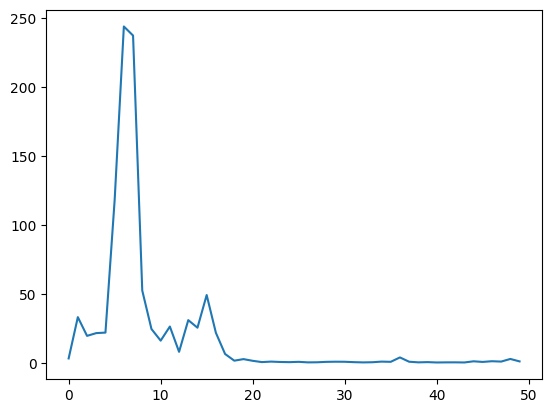

In [56]:
# Convert each tensor to a scalar
loss_list = [tensor.item() for tensor in all_losses]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)

https://aicontentfy.com/en/blog/step-by-step-text-generation-process-demystified

In [57]:
def Get_InputTensor_from_idNode(idNode):

    InputTensorDim = embeddingNbDimensions * (size_of_CP_to_learn(max_Carepath_lenght)-2)

    # Create an empty flat tensor of size (15,)
    Input_tensor = torch.zeros(InputTensorDim )

    #Define the star letter
    start_letter=carepath_to_tensor([idNode])
    start_letter=[tensor.flatten() for tensor in start_letter][0]

    # Append the values from star_letter tensor to the Input_tensor
    Input_tensor = torch.cat((Input_tensor, start_letter), dim=0)

    return Input_tensor

In [58]:
#PREDICT STEP
max_length = 50

# Sample from a starting NodeId and maxlength parameter
def sample(start_id,max_length):
    Predicted_Carepath=[start_id]
    with torch.no_grad():  # no need to track history in sampling
        input = Get_InputTensor_from_idNode(start_id)
        hidden = rnn.init_hidden()

        for i in range(max_length):
            output, hidden = rnn(input, hidden)
            Next_Acte=output[-3:].tolist()
            #Get the last Node from output 
            closest_node_id = Vec_2_node(Next_Acte, Dict_embedings)
            Predicted_Carepath.append(closest_node_id)
            if closest_node_id==End_acteid:
                break
            input=output

        return Predicted_Carepath

In [59]:
# Sample from a starting NodeId list and maxlength parameter
def sample_from_list(start_CP_list,max_length):
    Predicted_Carepath=start_CP_list
    StartCPlen=len(start_CP_list)

    with torch.no_grad():  # no need to track history in sampling
        input = Get_InputTensor_from_idNode(start_CP_list[0])
        hidden = rnn.init_hidden()

        for i in range(max_length):
            output, hidden = rnn(input, hidden)
            Next_Acte=output[-3:].tolist()
            #Get the last Node from output 
            closest_node_id = Vec_2_node(Next_Acte, Dict_embedings)
            
            if i >= StartCPlen-1 :
                Predicted_Carepath.append(closest_node_id)
            
            if closest_node_id==End_acteid:
                break
            input=output

        return Predicted_Carepath

In [60]:
testing_ids

[6, 11, 17, 14, 3, 16, 5, 12, 13]

In [61]:
NIP_Carepath[4]['SampleCareMatrix']

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  84,
  86],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  84,
  86,
  87],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  84,
  86,
  87,
  88],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [62]:
NIP_Carepath[4]['Carepath']

[84,
 86,
 87,
 88,
 88,
 89,
 90,
 88,
 91,
 92,
 92,
 93,
 94,
 92,
 95,
 96,
 92,
 97,
 98,
 92,
 99,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 48]

In [63]:
sample(3,6)

KeyError: 3

In [ ]:
sample_from_list([3091,3093,3094],6)

[3091, 3093, 3094, 3095, 3096, 3094, 3091]